In [4]:
import sys
sys.path.insert(0, "/home/tumay/code/data-context-and-setup")


In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Satıcılar

🎯 Amacımız, diğerlerine göre tekrarlı olarak düşük performans gösteren satıcıları bulmak ve nedenini anlamaktır.  
Bu, Olist'in gelecekte kâr marjını artırmaya yönelik önerilerimizi şekillendirmemize yardımcı olacaktır.

## 1 - `olist/seller.py`  

`order.py` ile benzer bir süreçte, size `olist/seller.py` modülünü sunduk; içinde `Seller` sınıfı ve `Seller().get_training_data` yöntemi bulunuyor. Bu yöntem aşağıdaki özellikleri içeren bir DataFrame döndürür:

| feature_name | type | açıklama |
| --- | --- | --- |
| `seller_id` | str | satıcının benzersiz kimliği (UNIQUE) |
| `seller_city` | str | satıcının bulunduğu şehir |
| `seller_state` | str | satıcının bulunduğu eyalet |
| `delay_to_carrier` | float | sipariş, `shipping_limit_date`'den önce teslim edildiyse 0 döner; aksi takdirde gecikme süresini verir |
| `wait_time` | float | satıcı başına ortalama teslimat süresi (bekleme süresi) |
| `date_first_sale` | datetime | Olist üzerinde yapılan ilk satışın tarihi |
| `date_last_sale` | datetime | Olist üzerindeki son satışın tarihi |
| `months_on_olist` | float | Olist'te geçirilen yaklaşık ay sayısı |
| `share_of_five_stars` | float | satıcının yer aldığı siparişlerdeki beş yıldız değerlendirmelerinin oranı |
| `share_of_one_stars` | float | satıcının yer aldığı siparişlerdeki bir yıldız değerlendirmelerinin oranı |
| `review_score` | float | satıcının yer aldığı siparişler için ortalama değerlendirme puanı |
| `n_orders` | int | satıcının yer aldığı benzersiz sipariş sayısı |
| `quantity` | int | bu satıcı tarafından satılan toplam ürün adedi |
| `quantity_per_order` | float | bu satıcı için sipariş başına ortalama ürün sayısı |
| `sales` | float | bu satıcı ile ilişkili toplam satış tutarı (kargo hariç), BRL cinsinden |

❓ **Aşağıya yeni sınıfınızı import edin ve eğitim veri çerçevenizi inceleyin!** Kodları incelemek için zaman ayırın ve sizin için tam olarak nelerin hesaplandığını anlayın.

In [5]:
from olist.seller import Seller

sellers = Seller().get_training_data()
sellers.head()

/home/tumay/code/data-context-and-setup/olist/seller.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(delay_to_logistic_partner)\
/home/tumay/code/data-context-and-setup/olist/seller.py:70: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(order_wait_time)\


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99


🤔 Her satıcı için henüz hesaplanması gereken bir şey kaldı:
- Aşırı yüksek değerlendirmelerin oranı (`share_of_five_stars`) ve aşırı düşük değerlendirmelerin oranı (`share_of_one_stars`)
- (ortalama) `review_score`

😱 Düşük puanlı her sipariş Olist'in itibarına olumsuz etki yapar; bu etki `cost_of_review` ile modellenir.

Bu, daha sonra her satıcı için toplam `cost_of_review`'u hesaplamamıza yardımcı olacak!

❓ **Sizin doldurmanız gereken son metod: `get_review_score()`'u implemente edin.**

In [13]:
    def get_review_score(self):
        orders_reviews = self.order.get_review_score()
        orders_sellers = self.data['order_items'][['order_id', 'seller_id']].drop_duplicates()

        df = orders_sellers.merge(orders_reviews, on='order_id')

        res = df.groupby('seller_id', as_index=False).agg({
            'dim_is_one_star': 'mean',
            'dim_is_five_star': 'mean',
            'review_score': 'mean'
        })

        res.columns = [
            'seller_id',
            'share_of_one_stars',
            'share_of_five_stars',
            'review_score'
        ]

        res['cost_of_reviews'] = 0.0
        return res



In [ ]:
def get_review_score(self):
    orders_reviews = self.order.get_review_score()[["order_id", "review_score"]]
    orders_sellers = self.data["order_items"][["order_id", "seller_id"]].drop_duplicates()

    df = orders_sellers.merge(orders_reviews, on="order_id", how="inner")

    res = df.groupby("seller_id", as_index=False).agg(
        share_of_one_stars=("review_score", lambda s: (s == 1).mean()),
        share_of_five_stars=("review_score", lambda s: (s == 5).mean()),
        review_score=("review_score", "mean"),
    )

    # profits hesabı için gerekli
    res["cost_of_reviews"] = 0.0

    return res[["seller_id", "share_of_one_stars", "share_of_five_stars", "review_score", "cost_of_reviews"]]


🧪 Kodunuzu aşağıda test edin

In [22]:
from nbresult import ChallengeResult

tmp = Seller().get_training_data()
result = ChallengeResult('seller',
    shape = tmp.shape,
    median = tmp.review_score.median(),
    columns = tmp.columns
)
result.write()
print(result.check())

/home/tumay/code/data-context-and-setup/olist/seller.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(delay_to_logistic_partner)\
/home/tumay/code/data-context-and-setup/olist/seller.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(order_wait_time)\



============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tumay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/tumay/code/data-sellers/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_seller.py::TestSeller::test_column_names PASSED                     [ 33%]
test_seller.py::TestSeller::test_median_review_score PASSED              [ 66%]
test_seller.py::TestSeller::test_shape FAILED                            [100%]

=================================== FAILURES ===================================
____________________________ TestSeller.test_shape _____________________________

self = <tests.test_seller.TestSeller testMethod=test_shape>

    def test_shape(self):
>       self.assertEqual(self.result.shape, (2967, 15),
                         msg="Expected exactly 2967 rows and 15 columns")
E       AssertionError: Tuples differ: (296

💡 **Tam satır sayısını elde edemiyor musunuz?**
<details><summary>Fazladan 3 satır mı var?</summary>
Left veya right join mi yaptınız? Nedenini anlıyoruz; fakat burada sadece değerlendirme alan satıcılarla ilgileniyoruz; bu yüzden inner join kullandık.
</details>
<details><summary>2 satır mı eksik?</summary>
`Orders().get_training_data()`'ı mı kullandınız? Bu geçerli bir seçenek, fakat sadece değerlendirmelerle ilgileniyorsak biraz aşırı olabilir. O method birçok hesaplama yapar ve döndürdüğü sütunların çoğuna ihtiyaç duymuyoruz. İhtiyacımıza daha uygun başka bir `Order` methodu bulun.
</details>

⚠️ `olist` reposundaki `seller.py` dosyasına yaptığınız kod değişikliklerini commit etmeyi unutmayın!

## 2 - Satıcıları İnceleme

### (2.1) Görselleştirmeler

Bu satıcılar hakkında ilk ***`EDA - Keşifsel Veri Analizi`*** ile başlayalım.

👉 `sellers` için özet istatistiklere bakın. Satıcı başına siparişlerin medyanı nedir ❓

In [23]:
sellers.describe()

,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales
count,2970.000000,2970.000000,2970,2970,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,0.402786,12.160414,2017-10-23 18:13:31.970033664,2018-04-25 03:14:27.046801408,6.110438,33.617508,37.859933,1.157178,4566.515906
min,0.000000,1.214178,2016-09-15 12:16:38,2016-10-06 15:44:56,0.000000,1.000000,1.000000,1.000000,6.500000
25%,0.000000,8.289263,2017-04-24 21:27:09.249999872,2018-02-12 23:14:41,1.000000,2.000000,3.000000,1.000000,239.800000
50%,0.000000,11.120969,2017-11-09 15:51:30.500000,2018-07-19 13:50:19.500000,4.000000,7.000000,8.000000,1.000000,893.500000
75%,0.000000,14.240673,2018-04-24 18:21:31.500000,2018-08-17 08:09:05.500000,10.000000,23.000000,26.000000,1.142857,3586.022500
max,45.434039,189.863160,2018-08-28 09:44:14,2018-09-03 17:40:06,23.000000,1854.000000,2033.000000,15.000000,229472.630000
std,2.391687,7.103208,NaN,NaN,6.085552,107.133714,121.458613,0.439363,14185.211617


👉 Bir sonraki adımda, veri setindeki her sayısal değişkenin dağılımını tek bir büyük görselde çizeceğiz. 

Kod size verildi, hücreyi çalıştırmanız yeterli.

- 👀 Herhangi bir aykırı değer fark ediyor musunuz?
- Sipariş sayısının dağılımı nasıl görünüyor ❓

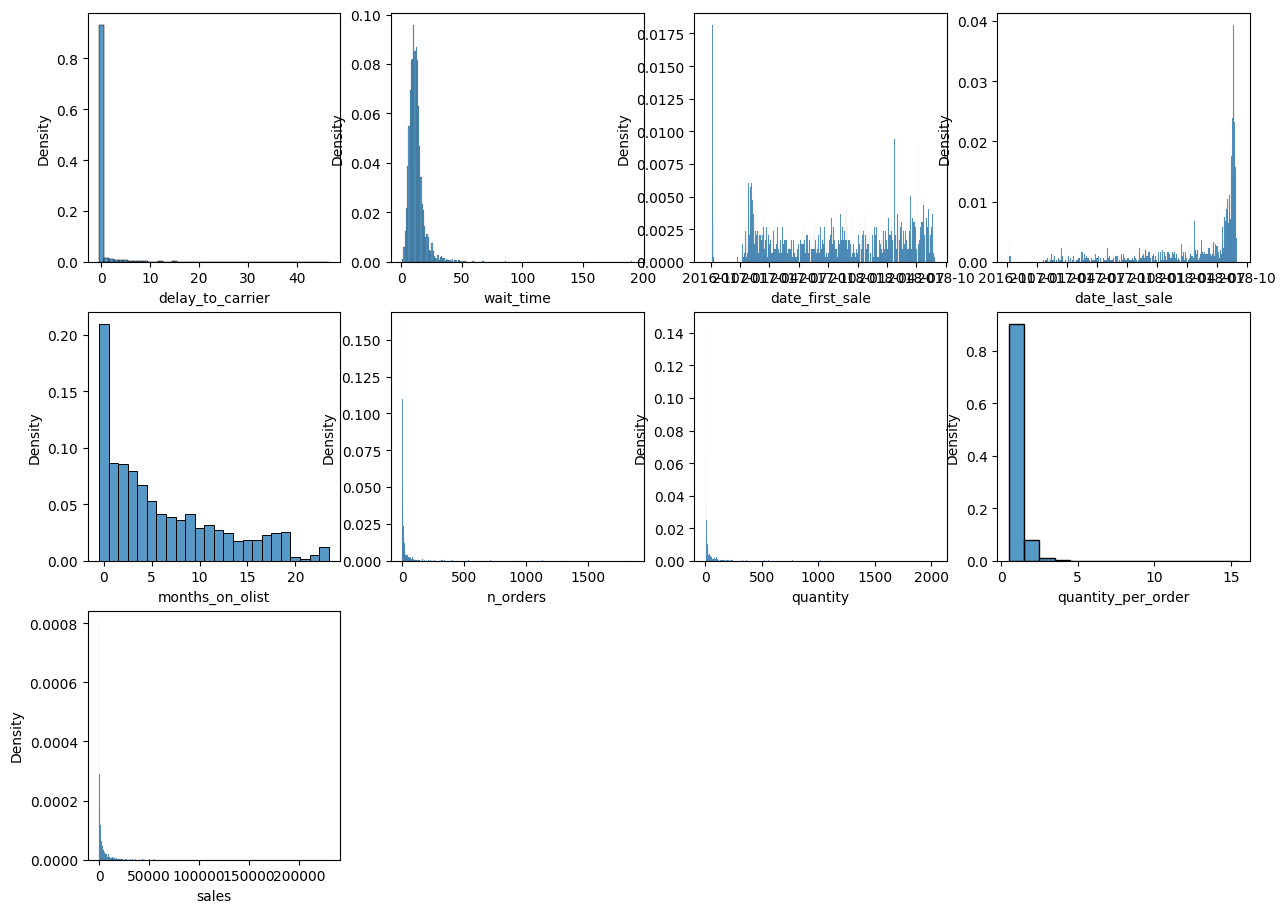

In [24]:
plt.figure(figsize=(15,11))
for (i, col) in enumerate(sellers.describe().columns):#["wait_time", "delay_to_carrier", "avg_review_score", "n_orders", "quantity", "price"]):
    plt.subplot(3,4,i+1)
    sns.histplot(sellers[col], kde=False, stat='density', discrete=[True,None][col in ['share_of_one_stars','share_of_five_stars','sales']]);

💡 Çok düşük değerlendirme puanlarına sahip bir grup satıcının öne çıktığı görünüyor!

📊 Grafiksel olarak inceleyelim:
- `plotly` kullanarak `delay_to_carrier` ile `wait_time` arasındaki ilişkiyi gösteren bir saçılma grafiği (scatterplot) oluşturuyoruz; kabarcık boyutunu satıcının toplam `sales`'i, rengini ise `review_score` belirliyor.

`plotly`'ı daha sonra detaylı göreceğiz; şimdilik aşağıdaki hücreyi çalıştırın.

In [41]:
import plotly.express as px
fig = px.scatter(data_frame = sellers[sellers['review_score'] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

In [26]:
sellers.columns


Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'n_orders', 'quantity', 'quantity_per_order', 'sales'],
      dtype='object')

In [30]:
import plotly.express as px

fig = px.scatter(
    data_frame=sellers,
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="sales",          # review_score yok, sales ile renklendiriyoruz
    size_max=60,
    opacity=0.5
)
fig.show()


In [31]:
from olist.seller import Seller

sellers = Seller().get_training_data()
sellers.columns


/home/tumay/code/data-context-and-setup/olist/seller.py:64: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/tumay/code/data-context-and-setup/olist/seller.py:69: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'n_orders', 'quantity', 'quantity_per_order', 'sales',
       'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'cost_of_reviews', 'revenues', 'profits'],
      dtype='object')

In [32]:
import plotly.express as px

fig = px.scatter(
    data_frame=sellers[sellers["review_score"] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max=60,
    opacity=0.5
)
fig.show()


In [33]:
from olist.seller import Seller
tmp = Seller().get_training_data()
tmp.columns, tmp.shape


/home/tumay/code/data-context-and-setup/olist/seller.py:64: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/tumay/code/data-context-and-setup/olist/seller.py:69: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



(Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
        'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
        'n_orders', 'quantity', 'quantity_per_order', 'sales',
        'share_of_one_stars', 'share_of_five_stars', 'review_score',
        'cost_of_reviews', 'revenues', 'profits'],
       dtype='object'),
 (2967, 18))

En kötü satıcıları bulmak için `x`, `y`, `color` ve `size` değerlerini değiştirmekten çekinmeyin.

### (2.2) `review_score`'u OLS ile modelleme

⚠️ Saçılma grafikleri veriyi görsel olarak analiz etmemizi sağlar, fakat sınırlamaları vardır: deneme-yanılma içerir ve ilişkileri yalnızca niteliksel değerlendiririz.

💡 **Satıcıların `review_score`** değişkenini açıklamak için daha sağlam bir yöntem, `statsmodels` içinde **çok değişkenli (multivariate) OLS** kullanarak çeşitli özelliklerin `review_score` üzerindeki etkisini modellemektir.

İstediğiniz sayısal özellikleri kullanarak bir OLS oluşturalım.

👉 Regresyon katsayılarını karşılaştırabilmek için önce aşağıdaki `standardize` fonksiyonunu kullanarak özelliklerinizi standardize edin.

In [27]:
def standardize(df, features):
    """Standardize specified numerical features in a DataFrame using z-score.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    features : list of str
        List of column names to standardize.

    Returns
    -------
    pandas.DataFrame
        A copy of the original dataframe where the specified features have been
        standardized to zero mean and unit variance. Other columns are left
        unchanged.
    """
    df_standardized = df.copy()
    mu = df[features].mean()
    sigma = df[features].std()
    df_standardized[features] = (df[features] - mu) / sigma
    return df_standardized

In [43]:
features = ['delay_to_carrier', 'wait_time', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)

👉 Sonraki adımda bir OLS modeli oluşturun ve fit edin.

In [44]:
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

❓ En etkili özellikler hangileri?

👉 Sıralanmış katsayılarla bir 📊 `bar_plot` çizin.

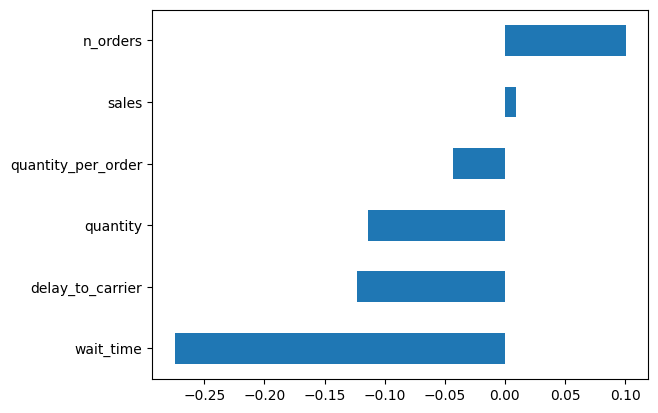

In [45]:
model.params[1:].sort_values().plot(kind='barh');

👉 Son olarak modelinizin performansını (`R-squared`) ve `residuals`'ı inceleyin

In [46]:
model.rsquared

0.19430209074601967

👉 Gerçek değerlendirme puanlarını ve modelin tahmin ettiği puanları aynı grafikte göstererek karşılaştırın.

<Axes: xlabel='review_score', ylabel='Density'>

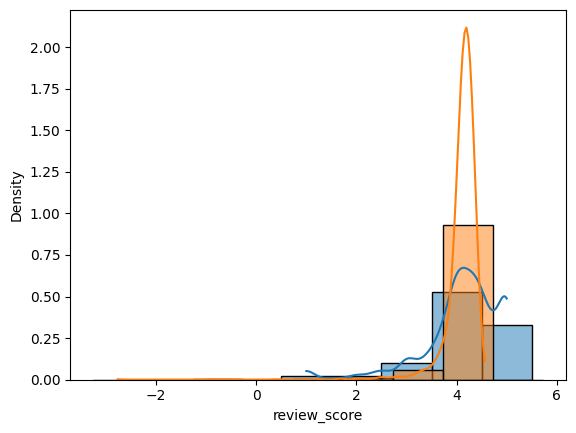

In [47]:
sns.histplot(sellers.review_score, kde=True, stat='density', discrete=True)
sns.histplot(model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True)

👉 Artıkları (residuals) görselleştirin

<Axes: ylabel='Density'>

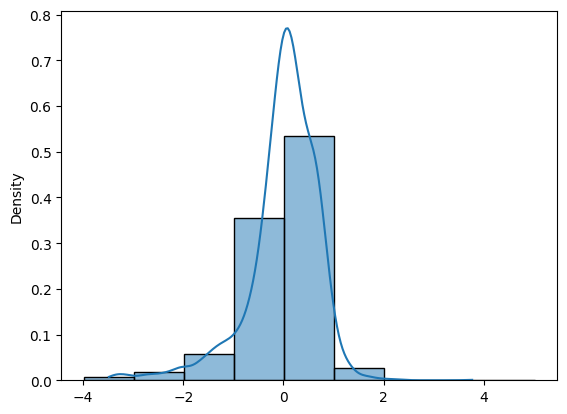

In [48]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True)

### (2.3) Analize `seller_state` bilgisini ekleyin

❓ Henüz `seller_state` bilgisini kullanmadık.  
- Sadece `seller_state`'lere karşı `review_score`'u regresyonla modelleyen yeni bir OLS oluşturun.
- `olist/utils.py` içinde sizin için yazılmış olan `return_significative_coef(model)` fonksiyonunu kullanarak anlamlı (significant) özellikleri analiz edin.
- `review_score` açısından en iyi eyaletler hangileri?

<details>
    <summary>- İpuçları -</summary>
        
⚠️ Dikkat, `seller_state` kategorik bir özelliktir. 
    
💡 Formülde kategorik değişkenleri belirtmek için `C(a_cat_feature)` kullanın. Bu, her benzersiz kategori için bir boolean değişken (`is_cat_feature_xx`) oluşturacaktır.

</details>

In [49]:
formula = 'review_score ~ C(seller_state)'
model2 = smf.ols(formula=formula, data=sellers).fit()

# top 5 coef with p-value < 0.05
from olist.utils import return_significative_coef
return_significative_coef(model2).tail()

,variable,p_value,coef
12,C(seller_state)[T.PE],0.034163,1.790505
15,C(seller_state)[T.RJ],0.028171,1.765621
1,C(seller_state)[T.BA],0.032503,1.761685
21,C(seller_state)[T.SP],0.030123,1.739509
3,C(seller_state)[T.DF],0.037168,1.698781


☝️ Bazı eyaletlerin ortalama olarak diğerlerinden _anlamlı_ biçimde daha iyi değerlendirmelere sahip olduğu görülebilir.

🤔 Bu, daha düşük `quantity_per_order`, daha kısa `wait_time` veya `delay_to_carrier`'dan mı kaynaklanıyor? Yoksa elimizde olmayan başka faktörlerden mi?

❓ **`seller_state` etkisini diğerlerinden izole etmeye çalışın: OLS modelinize sürekli (continuous) diğer özellikleri ekleyin; `seller_state` artık istatistiksel olarak anlamlı olmayana kadar devam edin!**

In [50]:
formula = 'review_score ~  sales + quantity + quantity_per_order + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)[1:]

,variable,p_value,coef
16,C(seller_state)[T.RN],0.014267,2.149534
4,C(seller_state)[T.ES],0.010618,2.092058
8,C(seller_state)[T.MS],0.025759,1.955813
11,C(seller_state)[T.PB],0.025146,1.936537
9,C(seller_state)[T.MT],0.034190,1.895819


In [51]:
formula = 'review_score ~ wait_time + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)[1:]

,variable,p_value,coef
22,wait_time,3.171865e-124,-0.04763


☝️ Analize `wait_time` ekledikten sonra, 22 adet `is_seller_state_xx` dummy değişkeninin hiçbirinin istatistiksel olarak anlamlı olmadığı görüldü:

Küçük veri setimiz göz önüne alındığında (çoğu eyalette çok az sayıda satıcı var):
- "Bazı eyaletlerin, `wait_time` dışındaki nedenlerle doğal olarak diğerlerinden daha iyi olduğu" sonucuna _varamayız_.
- Başka bir deyişle, "`seller_state`'in `wait_time` dışında `review_score` üzerinde etkisi yoktur" hipotezini reddedemeyiz.

🏁 Tebrikler!

💾 Commit ve push yapın:
- `sellers.ipynb` not defterinizi
- ayrıca `seller.py` dosyanızı